# Read data


In [1]:
import pandas as pd
import numpy as np
import itertools

# read news results dataset
dataset_A = pd.read_csv(f'data/dataset_A.csv')

# read the all news domain visists dataset
dataset_B = pd.read_csv(f'data/dataset_B.csv')

# read the Google associated visits dataset
dataset_C = pd.read_csv(f'data/dataset_C.csv')

# read the Google independent visits dataset
dataset_D = pd.read_csv(f'data/dataset_D.csv')

# include only the participants that were part of the statistical test
set_participants = set(dataset_A[dataset_A['is_selected_result']]['participant'])

In [2]:
dataset_B.columns

Index(['coredomain', 'participant', 'duration', 'is_search_engine_redirect',
       'is_analysis_period', 'is_google_search_associated_visit'],
      dtype='object')

# Define similarity functions (RBO and Jaccard)

In [3]:
from rbo import rbo


def group_rbo(df, gte, p, split_column='is_analysis_period'):
    
    selector = (df['total_visits']>=gte) & df['coredomain'].notnull()
    #selector = (df['visits'] >= gte) & df['coredomain'].notnull()
    
    before = df[~df[split_column] & selector].sort_values(
         ['visits', 'time_spent'], ascending=False)['coredomain']
    after = df[df[split_column] & selector].sort_values(
         ['visits', 'time_spent'], ascending=False)['coredomain']
    
    if len(before) > 0 and len(after) > 0:
        return gte, p, rbo(before, after, p=p).ext
    
    return gte, p,  None


def ji(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    
    # if both s1 and s2 are empty, the similarity is 0 (https://en.wikipedia.org/wiki/Jaccard_index)
    if len(s1) == 0 and len(s2) == 0:
        return 1
    else:    
        return float(len(s1.intersection(s2)) / len(s1.union(s2)))
    

def group_ji(df, gte, split_column='is_analysis_period'):
    
    # condition participants with more than x visits
    selector = (df['total_visits']>=gte)
    # condition participants with more than x visits in a given domain
    #selector = (df['visits'] >= gte)
    
    # is_after also discard the inputed values as long as the variable is of type boolean
    before = df[~df[split_column] & selector]['coredomain']
    after = df[df[split_column] & selector]['coredomain']
    
    # if we don't care about the number of visits, then include all the clients
    # considerig that ji will be 1 for two empty lists 
    if gte == 0:
        # discard the null coredomains that come from the inputations
        before = before[before.notnull()].tolist()
        after = after[after.notnull()].tolist()

    # if there is no rows, then mark this client_hash as missing. By definition, we do
    # not include jacard indexes in which there is no data for one of the tests
    elif len(before) == 0 or len(after) == 0:
        return None
    
    # return the jaccard similarity
    return ji(before, after)



# Similarity before vs after on Dataset B (all news)

In [4]:
# ount the number of visits and calculate the total time spent within the period after and before 
# the cuting date signaled by the is_analyses period flag
ranked_B =  dataset_B.groupby([ 'participant', 'coredomain', 'is_analysis_period'])['duration'].agg(
    ['size', 'sum']).rename(columns = {'size': 'visits', 'sum': 'time_spent'}).reset_index()


# consider all the participants
ranked_B = ranked_B.merge(
    # create the rows to impute the client_hashes that are not included in the 
    # aggregations because they are not represented, i.e., they had no visits
    pd.DataFrame(itertools.product(set_participants, [True, False]), columns=['participant', 'is_analysis_period']), 
    how='right', on=['participant', 'is_analysis_period'])

# boolean type properly handles NAs for the negation, i.e. ~NA = NA
ranked_B['is_analysis_period'] = ranked_B['is_analysis_period'].astype("boolean")

# fill missings with zeros
ranked_B['visits'] = ranked_B['visits'].fillna(0)
ranked_B['time_spent'] = ranked_B['time_spent'].fillna(0)
                              
# calculate the total number of visits per participant
ranked_B['total_visits']=ranked_B.groupby(['is_analysis_period','participant'])['visits'].transform('sum')

# Not plotted
# # RBO calculations
# params = [ (gte, p) for gte in [1, 5, 10] for p in [.15,.5,.7,.85,.95,.99]]
    
# # calculte the RBOs
# dfs = [ranked_B.groupby(['participant']).apply(
#         lambda x: group_rbo(x, gte=gte, p=p)).rename('response').to_frame().reset_index() for gte, p in params]

# #concatenate the dataframes
# results_rbo_B = pd.concat(dfs)

# # split the response
# results_rbo_B[['gte','p', 'rbo']] = pd.DataFrame(results_rbo_B['response'].tolist(), index=results_rbo_B.index)

# # calculate the remaining participants
# results_rbo_B['n'] = results_rbo_B.groupby(['gte', 'p'])['rbo'].transform('count')

# # create nice labels to plot
# results_rbo_B['gte_label'] = results_rbo_B['gte'].astype(str) + ' (n=' + results_rbo_B['n'].astype(str) + ')'



## Jacard 

In [5]:
# Jaccard calculations with different cuts
params = [1, 5, 10,]
sers = [ranked_B.groupby(['participant']).apply(
        lambda x: group_ji(x, gte=gte)) for gte in params]

# concatenate the series
results_ji_B = pd.concat(sers,  axis=1)

# name the columns according to the parameters
results_ji_B.columns = params

# print the summary
print(results_ji_B.describe())

# format the dataframe so it can be plotted in seaborn
results_ji_B = results_ji_B.unstack().reset_index().rename(columns = {'level_0': 'n', 0: 'ji'})

               1           5           10
count  252.000000  219.000000  193.000000
mean     0.276748    0.295072    0.308953
std      0.166053    0.156374    0.144796
min      0.000000    0.000000    0.000000
25%      0.165698    0.181818    0.200000
50%      0.254032    0.280000    0.285714
75%      0.384615    0.394444    0.407407
max      1.000000    1.000000    0.750000


# Similarity before vs after on Dataset D (Google independent)

## RBO

In [6]:
# define the rank within the period after and before the cuting date signaled by the is_analyses period flag
ranked_D =  dataset_D.groupby([ 'participant', 'coredomain', 'is_analysis_period'])['duration'].agg(
    ['size', 'sum']).rename(columns = {'size': 'visits', 'sum': 'time_spent'}).reset_index()

# consider all the participants
ranked_D = ranked_D.merge(
    # create the rows to impute the client_hashes that are not included in the 
    # aggregations because they are not represented, i.e., they had no visits
    pd.DataFrame(itertools.product(set_participants, [True, False]), columns=['participant', 'is_analysis_period']), 
    how='right', on=['participant', 'is_analysis_period'])

# boolean type properly handles NAs for the negation, i.e. ~NA = NA
ranked_D['is_analysis_period'] = ranked_D['is_analysis_period'].astype("boolean")

# fill missings with zeros
ranked_D['visits'] = ranked_D['visits'].fillna(0)
ranked_D['time_spent'] = ranked_D['time_spent'].fillna(0)

# calculate the total number of visits per participant
ranked_D['total_visits']=ranked_D.groupby(['is_analysis_period','participant'])['visits'].transform('sum')

# RBO calculations
params = [ (gte, p) for gte in [1, 5, 10] for p in [.15,.5,.7,.85,.95,.99]]
    
# calculte the RBOs
dfs = [ranked_D.groupby(['participant']).apply(
        lambda x: group_rbo(x, gte=gte, p=p)).rename('response').to_frame().reset_index() for gte, p in params]

#concatenate the dataframes
results_rbo_D = pd.concat(dfs)

# split the response
results_rbo_D[['gte','p', 'rbo']] = pd.DataFrame(results_rbo_D['response'].tolist(), index=results_rbo_D.index)

# calculate the remaining participants
results_rbo_D['n'] = results_rbo_D.groupby(['gte', 'p'])['rbo'].transform('count')

# create nice labels to plot
results_rbo_D['gte_label'] = results_rbo_D['gte'].astype(str) + ' (n=' + results_rbo_D['n'].astype(str) + ')'

# print summary
results_rbo_D.groupby(['gte','gte_label', 'p'])['rbo'].describe()

count      mean       std  min       25%       50%  \
gte gte_label  p                                                          
1   1 (n=226)  0.15  226.0  0.684236  0.430795  0.0  0.142821  0.928933   
               0.50  226.0  0.673236  0.357068  0.0  0.434578  0.790625   
               0.70  226.0  0.658461  0.318912  0.0  0.537989  0.721648   
               0.85  226.0  0.636854  0.293235  0.0  0.493035  0.685892   
               0.95  226.0  0.607778  0.281245  0.0  0.471560  0.637602   
               0.99  226.0  0.587297  0.280338  0.0  0.440967  0.597530   
5   5 (n=190)  0.15  190.0  0.738298  0.396800  0.0  0.152311  0.929025   
               0.50  190.0  0.721334  0.305491  0.0  0.504167  0.799470   
               0.70  190.0  0.702378  0.258045  0.0  0.597729  0.738467   
               0.85  190.0  0.677036  0.227292  0.0  0.547325  0.695647   
               0.95  190.0  0.644177  0.216495  0.0  0.509108  0.644050   
               0.99  190.0  0.621047  0.219364  0.0  0.492550  0.605795   
10  10 (n=165) 0.15  165.0  0.760113  0.384636  0.0  0.920977  0.935334   
               0.50  165.0  0.742663  0.294370  0.0  0.698611  0.837202   
               0.70  165.0  0.722670  0.247034  0.0  0.601644  0.780701   
               0.85  165.0  0.695800  0.215568  0.0  0.576822  0.706516   
               0.95  165.0  0.660790  0.204984  0.0  0.529546  0.657688   
               0.99  165.0  0.635922  0.209161  0.0  0.505000  0.634241   

                          75%       max  
gte gte_label  p                         
1   1 (n=226)  0.15  0.999736  1.024932  
               0.50  0.983060  1.076042  
               0.70  0.942264  1.076536  
               0.85  0.864228  1.026595  
               0.95  0.841700  1.000000  
               0.99  0.838300  1.000000  
5   5 (n=190)  0.15  0.997766  1.024792  
               0.50  0.963542  1.062500  
               0.70  0.906908  1.038920  
               0.85  0.847384  1.000000  
               0.95  0.804404  1.000000  
               0.99  0.796012  1.000000  
10  10 (n=165) 0.15  0.999183  1.024792  
               0.50  0.969952  1.062500  
               0.70  0.914534  1.038920  
               0.85  0.850000  1.000000  
               0.95  0.804637  1.000000  
               0.99  0.796463  1.000000

## Jacard 

In [7]:
# Jaccard calculations with different cuts
params = [1, 5, 10]
sers = [ranked_D.groupby(['participant']).apply(
        lambda x: group_ji(x, gte=gte)) for gte in params]

# concatenate the series
results_ji_D = pd.concat(sers,  axis=1)

# name the columns according to the parameters
results_ji_D.columns = params

# print the summary
print(results_ji_D.describe())

# format the dataframe so it can be plotted in seaborn
results_ji_D = results_ji_D.unstack().reset_index().rename(columns = {'level_0': 'n', 0: 'ji'})

               1           5           10
count  226.000000  190.000000  165.000000
mean     0.422910    0.438698    0.448924
std      0.270232    0.231928    0.228581
min      0.000000    0.000000    0.000000
25%      0.250000    0.285714    0.300000
50%      0.379808    0.400000    0.400000
75%      0.543706    0.543706    0.545455
max      1.000000    1.000000    1.000000


# Similarity before vs after on Dataset C (Google associated)


## RBO

In [8]:
# define the rank with the time selector
ranked_C =  dataset_C.groupby([ 'participant', 'coredomain', 'is_analysis_period'])['duration'].agg(
    ['size', 'sum']).rename(columns = {'size': 'visits', 'sum': 'time_spent'}).reset_index()

# consider all the participants
ranked_C = ranked_C.merge(
    # create the rows to impute the client_hashes that are not included in the 
    # aggregations because they are not represented, i.e., they had no visits
    pd.DataFrame(itertools.product(set_participants, [True, False]), columns=['participant', 'is_analysis_period']), 
    how='right', on=['participant', 'is_analysis_period'])

# boolean type properly handles NAs for the negation, i.e. ~NA = NA
ranked_C['is_analysis_period'] = ranked_C['is_analysis_period'].astype("boolean")

# fill missings with zeros
ranked_C['visits'] = ranked_C['visits'].fillna(0)
ranked_C['time_spent'] = ranked_C['time_spent'].fillna(0)

# calculate the total number of visits per participant
ranked_C['total_visits']=ranked_C.groupby(['is_analysis_period','participant'])['visits'].transform('sum')

# RBO calculations
params = [ (gte, p) for gte in [1,5,10] for p in [.15,.5,.7,.85,.95,.99]]
    
# calculte the RBOs
dfs = [ranked_C.groupby(['participant']).apply(
        lambda x: group_rbo(x, gte=gte, p=p)).rename('response').to_frame().reset_index() for gte, p in params]

#concatenate the dataframes
results_rbo_C = pd.concat(dfs)

# split the response
results_rbo_C[['gte','p', 'rbo']] = pd.DataFrame(results_rbo_C['response'].tolist(), index=results_rbo_C.index)

# calculate the remaining participants
results_rbo_C['n'] = results_rbo_C.groupby(['gte', 'p'])['rbo'].transform('count')

# create nice labels to plot
results_rbo_C['gte_label'] = results_rbo_C['gte'].astype(str) + ' (n=' + results_rbo_C['n'].astype(str) + ')'

# print summary
results_rbo_C.groupby(['gte','gte_label', 'p'])['rbo'].describe()

count      mean       std  min       25%       50%  \
gte gte_label p                                                          
1   1 (n=230) 0.15  230.0  0.223101  0.384433  0.0  0.000000  0.007193   
              0.50  230.0  0.237238  0.317991  0.0  0.000000  0.069910   
              0.70  230.0  0.246658  0.281750  0.0  0.000000  0.123040   
              0.85  230.0  0.253025  0.256401  0.0  0.000000  0.215138   
              0.95  230.0  0.251428  0.242723  0.0  0.000000  0.227863   
              0.99  230.0  0.244894  0.238651  0.0  0.000000  0.219955   
5   5 (n=137) 0.15  137.0  0.325209  0.429000  0.0  0.000817  0.071370   
              0.50  137.0  0.334908  0.331925  0.0  0.028684  0.210565   
              0.70  137.0  0.342449  0.274370  0.0  0.094150  0.288894   
              0.85  137.0  0.349356  0.232717  0.0  0.168940  0.336772   
              0.95  137.0  0.348719  0.212788  0.0  0.190301  0.345908   
              0.99  137.0  0.340818  0.210359  0.0  0.197812  0.336059   
10  10 (n=90) 0.15   90.0  0.381706  0.440044  0.0  0.007544  0.075040   
              0.50   90.0  0.389071  0.322072  0.0  0.092620  0.254447   
              0.70   90.0  0.393338  0.251884  0.0  0.196851  0.353986   
              0.85   90.0  0.398293  0.201564  0.0  0.260830  0.381879   
              0.95   90.0  0.396508  0.180578  0.0  0.286048  0.378487   
              0.99   90.0  0.385895  0.182351  0.0  0.278465  0.376147   

                         75%       max  
gte gte_label p                         
1   1 (n=230) 0.15  0.085312  1.024932  
              0.50  0.294734  1.076042  
              0.70  0.431995  1.076536  
              0.85  0.430072  1.026595  
              0.95  0.420324  1.000000  
              0.99  0.407351  1.000000  
5   5 (n=137) 0.15  0.921041  1.024792  
              0.50  0.706367  1.062500  
              0.70  0.568333  1.038920  
              0.85  0.516755  1.000000  
              0.95  0.484899  1.000000  
              0.99  0.457273  1.000000  
10  10 (n=90) 0.15  0.921210  0.999888  
              0.50  0.711965  0.981845  
              0.70  0.592954  0.917268  
              0.85  0.536194  0.841461  
              0.95  0.525672  0.867325  
              0.99  0.502145  0.888119

## Jaccard

In [9]:
# Jaccard calculations
params = [1, 5, 10]
sers = [ranked_C.groupby(['participant']).apply(
        lambda x: group_ji(x, gte=gte)) for gte in params]


# concatenate the series
results_ji_C = pd.concat(sers,  axis=1)

# name the columns according to the parameters
results_ji_C .columns = params

# print the summary
print(results_ji_C.describe())

# format the dataframe so it can be plotted in seaborn
results_ji_C = results_ji_C.unstack().reset_index().rename(columns = {'level_0': 'n', 0: 'ji'})

               1           5          10
count  230.000000  137.000000  90.000000
mean     0.154322    0.211743   0.238314
std      0.161456    0.161788   0.147655
min      0.000000    0.000000   0.000000
25%      0.000000    0.100000   0.142857
50%      0.135945    0.181818   0.218254
75%      0.239524    0.285714   0.305769
max      1.000000    1.000000   0.750000


# Integrated plot

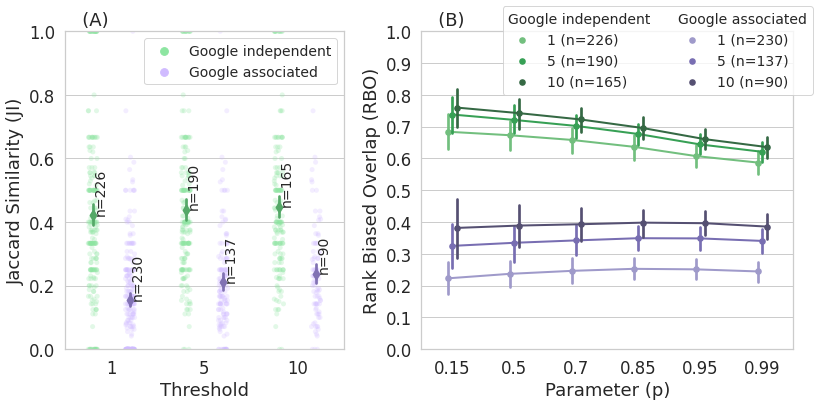

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.text as mtext

sns.set(style="whitegrid", font_scale=1.5)
fig, ax = plt.subplots(1,2, figsize=(12,6), gridspec_kw={'width_ratios': [4.5, 6]})

# name each dataset before concatenatin them
results_ji_D['Data set'] = 'Google independent'
results_ji_C['Data set'] = 'Google associated'

# concatenate the Jaccard similaraties calculated in each dataset
results_ji = pd.concat([results_ji_C, results_ji_D])

# label order
hue_order = ['Google independent', 'Google associated']


################################
# Plot A: Jaccard similarities #
################################
sp = sns.stripplot(y='ji', 
                   x='n', 
                   data=results_ji,
        
                   # order = y_order,
                   dodge=True,
                   alpha=.25,
                   # palette = [sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[3]],
                   zorder=1,
                   # ax = ax[1]
                   
                   hue='Data set',
                   hue_order = hue_order,
                   #ci=95,
                   palette = [sns.color_palette('pastel')[2], sns.color_palette('pastel')[4], sns.color_palette('pastel')[1]],
                   ax = ax[0]
                  )


pp = sns.pointplot(y='ji', 
                   x='n',
                   data=results_ji,
                   #order = y_order,
                   dodge=.8 - .8 / 2,
                   join=False,
                   #palette = [sns.color_palette('dark')[2], sns.color_palette('dark')[4], sns.color_palette('dark')[3]],
                   markers='d', 
                   scale=1,
                   
                   #ci=95,
                   
                   hue='Data set',
                   hue_order = hue_order,
                   ci=95,
                   palette = [sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[1]],
                   ax = sp
                  )


bp = sns.barplot(x="n", 
               y="ji",
               data=results_ji,
               hue='Data set',
               hue_order = hue_order,
                 alpha=0,
               ci=None,
               palette = ['white'],
               ax = pp)


# bp = sns.barplot(x="n", 
#                y="ji",
#                data=results_ji,
#                hue='Data set',
#                hue_order = hue_order,
#                ci=95,
#                palette = [sns.color_palette('pastel')[2], sns.color_palette('pastel')[4], sns.color_palette('pastel')[1]],
#                ax = ax[0])

# display the full possible scale
bp.set(ylim=(0, 1))

# add titles and labels
bp.set_ylabel('Jaccard Similarity (JI)')
bp.set_xlabel('Threshold')
bp.set_title('   (A)', loc='left')

# remove legend title
bp.legend()

# Improve the legend
handles, labels = bp.get_legend_handles_labels()
bp.legend(handles[:2], labels[:2], 
          #handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True, fontsize=14)


# parameters to personalize the bar labels
_params = {
    'label_type':'edge', 
    'padding':0, 
    'rotation':90, 
    'fontsize':14, 
    'fontstretch':'ultra-condensed', 
    'fontweight':'ultralight'
}

# personalize the bar so that the number of participants appear on it
bp.bar_label(bp.containers[0], 
             labels = [ f'\nn={l}' for l in results_ji_D.groupby('n')['ji'].count()], **_params)
bp.bar_label(bp.containers[1], 
             labels = [ f'\nn={l}' for l in results_ji_C.groupby('n')['ji'].count()], **_params)



############################
# Plot B: RBO Similarities #
############################

# adding spaces to make the increas the width of the legend
results_rbo_D['gte_label'] = results_rbo_D['gte_label'].str.strip() + '     '


# plot rbo in google independent
pp = sns.pointplot(x="p", 
                   y="rbo", 
                   data=results_rbo_D,
                   hue='gte_label',
                   join=True, 
                   scale=.75, 
                   ci=95,
                   palette = 'Greens_d',  
                   dodge=.15,
                   # errwidth=3,
                   ax=ax[1]

                  )


# plot rbo in google associated
pp = sns.pointplot(x="p", 
                   y="rbo", 
                   data=results_rbo_C,
                   hue='gte_label',
                   join=True, 
                   scale=.75, 
                   ci=95,
                   palette = 'Purples_d',
                   dodge=.15,
                   ax=ax[1]
                  )


# increase the number of reference horizontal lines
pp.set_yticks(np.arange(0, 1.01, 0.1))

# display the full scale
pp.set(ylim=(0, 1))

# add labels and titles
pp.set_ylabel('Rank Biased Overlap (RBO)')
pp.set_xlabel('Parameter (p)')
pp.set_title('   (B)', loc='left')

# customize the legend by affect the titles
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
        handlebox.add_artist(title)
        return title

# extract he current legend
h,l = pp.get_legend_handles_labels()

# estructure the legend introducing placeholders to separate the categories
pp.legend(['Google independent'] + h[:3] + ['Google associated']    + h[3:6], 
          ['']                   + l[:3] + ['                    '] + l[3:6],
           handler_map={str: LegendTitle({'fontsize': 14})},
           bbox_to_anchor=(0.2, 1.1), fontsize=14, ncol=2)

# readjust the plot
plt.tight_layout()